# Step 1. Import data
- Load data
- Load package

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pycaret.regression import *

raw_df_RHF  = pd.read_csv("Step_1_Simulation_to_ML.csv" , encoding='cp949')

# Step 2. Training data
- Prediction - Algorithm selection - Save to .pkl

In [ ]:
from pycaret.regression import *
setup(data = raw_df_RHF, numeric_features=['CbyO','Temp','Time'], ignore_features=['Deg_M'], target = 'Deg_Z', session_id=123, log_experiment = False, normalize= True, silent=True)

In [ ]:
Deg_Z = compare_models()

In [ ]:
Deg_Z_xgb = create_model('xgboost')
evaluate_model(Deg_Z_xgb)

In [ ]:
predictions_et=predict_model(Deg_Z_xgb, data=raw_df_RHF)
predictions_et.plot(x='Deg_Z', y='Label', kind='scatter')

In [ ]:
save_model(Deg_Z_xgb, 'Predict_Z')

In [ ]:
from pycaret.regression import *
setup(data = raw_df_RHF, numeric_features=['CbyO','Temp','Time'], ignore_features=['Deg_Z'], target = 'Deg_M', session_id=123, log_experiment = False, normalize= True, silent=True)

In [ ]:
Deg_M = compare_models()

In [ ]:
Deg_M_xgb = create_model('xgboost')
evaluate_model(Deg_M_xgb)

In [ ]:
predictions_et=predict_model(Deg_M_xgb, data=raw_df_RHF)
predictions_et.plot(x='Deg_M', y='Label', kind='scatter')

In [ ]:
save_model(Deg_M_xgb, 'Predict_M')

# Step 3. Test
- Load model (.pkl)
- Compare the predcition results with mathematical model

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pycaret.regression import *

Model_M = load_model ('Predict_M')
Model_Z = load_model ('Predict_Z')

In [ ]:
c = pd.Series (np.linspace(1,80,80))

test_df_01 = pd.DataFrame({'CbyO':8.0 ,'Temp':-5,'Time':c } )
test_df_02 = pd.DataFrame({'CbyO':8.6 ,'Temp':-5,'Time':c } )
test_df_03 = pd.DataFrame({'CbyO':9.2 ,'Temp':-5,'Time':c } )
test_df_04 = pd.DataFrame({'CbyO':9.8 ,'Temp':-5,'Time':c } )
test_df_05 = pd.DataFrame({'CbyO':10.4,'Temp':-5,'Time':c } )
test_df_06 = pd.DataFrame({'CbyO':11.0,'Temp':-5,'Time':c } )

test_df_07 = pd.DataFrame({'CbyO':8.9,'Temp':-50,'Time':c } )
test_df_08 = pd.DataFrame({'CbyO':8.9,'Temp':-20,'Time':c } )
test_df_09 = pd.DataFrame({'CbyO':8.9,'Temp':10 ,'Time':c } )
test_df_10 = pd.DataFrame({'CbyO':8.9,'Temp':40 ,'Time':c } )
test_df_11 = pd.DataFrame({'CbyO':8.9,'Temp':70 ,'Time':c } )
test_df_12 = pd.DataFrame({'CbyO':8.9,'Temp':100,'Time':c } )

test_df    = pd.concat([ test_df_01, test_df_02, test_df_03, test_df_04, test_df_05, test_df_06, 
                         test_df_07, test_df_08, test_df_09, test_df_10, test_df_11, test_df_12 ])

prediction_M = predict_model (Model_M, data = test_df)
prediction_Z = predict_model (Model_Z, data = test_df)

In [ ]:
save_csv_1 = pd.DataFrame(prediction_M).to_csv('ML_M.csv')
save_csv_2 = pd.DataFrame(prediction_Z).to_csv('ML_Z.csv')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pycaret.regression import *

Model_M = load_model ('Predict_M')
Model_Z = load_model ('Predict_Z')

Test_df_RHF  = pd.read_csv("Step_3_ML_Test_lhs.csv" , encoding='cp949') # lhs = latin-hypercub sampling

Test_M = predict_model (Model_M, data = Test_df_RHF)
Test_Z = predict_model (Model_Z, data = Test_df_RHF)

In [ ]:
Test_M_to_xls = pd.DataFrame(Test_M).to_csv('Step_3_Test_results_M.csv')
Test_Z_to_xls = pd.DataFrame(Test_Z).to_csv('Step_3_Test_results_Z.csv')

# Step 4. Analysis of the prediction model
- load .pkl
- Evaluate SHAP

In [73]:
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from pycaret.regression import *
# Time: 15, 30, 45 (three cases), target = 'Deg_Z', 'Deg_M' (two cases)
setup(data = raw_df_RHF[(raw_df_RHF['Time']==45)], numeric_features=['CbyO','Temp'], ignore_features=['Deg_Z','Time'], target = 'Deg_M', session_id=123, log_experiment = False, normalize= True, silent=True)

Deg_xgb       = create_model('xgboost')
training_data = get_config(variable = "X_train")
explainer     = shap.Explainer(model = Deg_xgb)
SHAP_values   = explainer(training_data)


,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.1390,0.0381,0.1952,0.9983,0.0025,0.0018
1,0.2158,0.0947,0.3077,0.9937,0.0038,0.0027
2,0.1631,0.0583,0.2414,0.9962,0.0031,0.0021
3,0.1300,0.0286,0.1692,0.9985,0.0020,0.0016
4,0.1726,0.0550,0.2345,0.9965,0.0029,0.0022
5,0.1572,0.0440,0.2097,0.9978,0.0025,0.0019
6,0.1383,0.0339,0.1841,0.9980,0.0024,0.0018
7,0.1839,0.0810,0.2846,0.9968,0.0036,0.0023
8,0.1409,0.0320,0.1789,0.9988,0.0022,0.0017
9,0.1330,0.0325,0.1802,0.9984,0.0023,0.0017


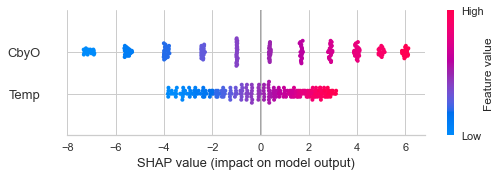

In [74]:
def beeswarm_plot(SHAP_values):
    return shap.plots.beeswarm(SHAP_values, show = False)
plt.clf()
beeswarm_plot(SHAP_values)

plt.savefig("XGB_M_45min.png",dpi=600, bbox_inches='tight')

# Step 5. Opt (1) - Productivity (constraint: DegZ)
- Single optimization with single constraint
- Case study for Zinc input weight variation (3, 7, 11 wt.%)

In [ ]:
### 
# Single optimization with constraint
# Deg_Z < 83.3 for Case-A1
# Deg_Z < 92.9 for Case-A2
# Deg_Z < 95.5 for Case-A3
###

import optuna # Dezincification vs Metallization
from pycaret.regression import *

Model_Z = load_model('Predict_Z') 

def Single_opt_case_a1(trial):
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   15, 60)
    
    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_Z = predict_model ( Model_Z , data = test_df )
    
    Dezincification = prediction_Z['Label'][0]

    if Dezincification >= 83.3:
        const_1 = 1
    else:
        const_1 = 1000

    Productivity = 200000 * (20/c)/const_1

    return(Productivity)

def Single_opt_case_a2(trial):
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   15, 60)
    
    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_Z = predict_model ( Model_Z , data = test_df )
    
    Dezincification = prediction_Z['Label'][0]

    if Dezincification >= 92.9:
        const_1 = 1
    else:
        const_1 = 1000

    Productivity = 200000 * (20/c)/const_1

    return(Productivity)


def Single_opt_case_a3(trial):
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   15, 60)
    
    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_Z = predict_model ( Model_Z , data = test_df )
    
    Dezincification = prediction_Z['Label'][0]

    if Dezincification >= 95.5:
        const_1 = 1
    else:
        const_1 = 1000

    Productivity = 200000 * (20/c)/const_1

    return(Productivity)

In [ ]:
import optuna
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice
from optuna.samplers import TPESampler


sampler = TPESampler(seed=10) 

Opt_case_a1 = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(), sampler=sampler)
Opt_case_a1.optimize( Single_opt_case_a1 , n_trials = 800 )

Opt_case_a2 = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(), sampler=sampler)
Opt_case_a2.optimize( Single_opt_case_a2 , n_trials = 800 )

Opt_case_a3 = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner(), sampler=sampler)
Opt_case_a3.optimize( Single_opt_case_a3 , n_trials = 800 )

Opt_case_a1       = Opt_case_a1.trials_dataframe(attrs=("number","value","params","state"))
save_case_a1_csv  = Opt_case_a1.to_csv('Step_5_Single_opt_A1_trial.csv')

Opt_case_a2       = Opt_case_a2.trials_dataframe(attrs=("number","value","params","state"))
save_case_a2_csv  = Opt_case_a2.to_csv('Step_5_Single_opt_A2_trial.csv')

Opt_case_a3       = Opt_case_a3.trials_dataframe(attrs=("number","value","params","state"))
save_case_a3_csv  = Opt_case_a3.to_csv('Step_5_Single_opt_A3_trial.csv')


# Step 6. Opt (2) - DegZ vs DegM
- Multi objective optimization
- Pareto-solution between DegZ vs DegM
- Operational time was fixed
- Five different times were evaluated (20, 25, 30, 35, 40 min)

In [ ]:
import optuna # Dezincification vs Metallization
from pycaret.regression import *

Model_M = load_model('Predict_M')
Model_Z = load_model('Predict_Z') 

def MOO_callback_1(trial):
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   20, 20)

    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_M = predict_model ( Model_M , data = test_df )
    prediction_Z = predict_model ( Model_Z , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
    
    return Metallization, Dezincification

def MOO_callback_2(trial):
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   25, 25)

    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_M = predict_model ( Model_M , data = test_df )
    prediction_Z = predict_model ( Model_Z , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
    
    return Metallization, Dezincification

def MOO_callback_3(trial):
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   30, 30)

    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_M = predict_model ( Model_M , data = test_df )
    prediction_Z = predict_model ( Model_Z , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
    
    return Metallization, Dezincification

def MOO_callback_4(trial):
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   35, 35)

    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_M = predict_model ( Model_M , data = test_df )
    prediction_Z = predict_model ( Model_Z , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
    
    return Metallization, Dezincification

def MOO_callback_5(trial):
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   40, 40)

    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_M = predict_model ( Model_M , data = test_df )
    prediction_Z = predict_model ( Model_Z , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
    
    return Metallization, Dezincification

In [ ]:
import pandas as pd

## Results: no Pareto-Front solution was observed because both of the objective function had same directions
############ Time-front (1) 20 min ############
MOO_study_1 = optuna.create_study(directions=["maximize", "maximize"])
MOO_study_1.optimize(MOO_callback_1, n_trials=200)
print("Number of finished trials: ", len(MOO_study_1.trials))

trials_df_1 = MOO_study_1.trials_dataframe(attrs=("number","value","params","state"))
save_csv_1  = trials_df_1.to_csv('Step_6_MOO_1_20min.csv')

############ Time-front (2) 25 min ############
MOO_study_2 = optuna.create_study(directions=["maximize", "maximize"])
MOO_study_2.optimize(MOO_callback_2, n_trials=200)
print("Number of finished trials: ", len(MOO_study_2.trials))

trials_df_2 = MOO_study_2.trials_dataframe(attrs=("number","value","params","state"))
save_csv_2  = trials_df_2.to_csv('Step_6_MOO_2_25min.csv')

############ Time-front (3) 30 min ############
MOO_study_3 = optuna.create_study(directions=["maximize", "maximize"])
MOO_study_3.optimize(MOO_callback_3, n_trials=200)
print("Number of finished trials: ", len(MOO_study_3.trials))

trials_df_3 = MOO_study_3.trials_dataframe(attrs=("number","value","params","state"))
save_csv_3  = trials_df_3.to_csv('Step_6_MOO_3_30min.csv')

############ Time-front (4) 50 min ############
MOO_study_4 = optuna.create_study(directions=["maximize", "maximize"])
MOO_study_4.optimize(MOO_callback_4, n_trials=200)
print("Number of finished trials: ", len(MOO_study_4.trials))

trials_df_4 = MOO_study_4.trials_dataframe(attrs=("number","value","params","state"))
save_csv_4  = trials_df_4.to_csv('Step_6_MOO_4_35min.csv')

############ Time-front (5) 40 min ############
MOO_study_5 = optuna.create_study(directions=["maximize", "maximize"])
MOO_study_5.optimize(MOO_callback_5, n_trials=200)
print("Number of finished trials: ", len(MOO_study_5.trials))

trials_df_5 = MOO_study_5.trials_dataframe(attrs=("number","value","params","state"))
save_csv_5  = trials_df_5.to_csv('Step_6_MOO_5_40min.csv')

# Step 7. Opt (3) - Carbon emission penalty vs Productivity
- Multi objective optimization with single constraint (Deg M > 60)
- Pareto-solution between OPEX vs Productivity
- CO2 emission penalty cost was included in OPEX
- Three different penalty costs were analyzed (40, 80, 120 US$/tCO2)

- Case study
  + b1: Deg_M: 60 & CO2: 40
  + b2: Deg_M: 90 & CO2: 120
  + b3: Deg_M: 60 & CO2: 40
  + b4: Deg_M: 90 & CO2: 120
  + b5: Deg_M: 60 & CO2: 80
  + b6: Deg_M: 90 & CO2: 120

In [ ]:
import optuna # Dezincification vs Metallization
from pycaret.regression import *

Model_M = load_model('Predict_M')
Model_Z = load_model('Predict_Z') 

def Single_opt_case_b1(trial):
##############################################################################################################
    ### Seed sampling
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   15, 60)
    
    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_Z = predict_model ( Model_Z , data = test_df )
    prediction_M = predict_model ( Model_M , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
##############################################################################################################
    ### Objective 1 = Productivity
    if Metallization >= 60.0:
        const_1 = 1
    else:
        const_1 = 10000 # Soft constraint!

    Productivity = 200000 * (20/c)/const_1 # Unit: t/yr, 20 Mt/y = Commercial-scale (POSCO-Nippon Steel plant)
##############################################################################################################
    ### Objective 2 = OPEX
    ## RHF Mass and Heat balance link
    ## Reference: D:\02_RHF_modelling\5_Pellet_Mfile\R17_220404_Optimization_integration
    Dezinc              = Dezincification / 100
    C_frac              = a / 100 
    Fe2O3_frac          = 0.2597 # Reference
    Metalliz            = Metallization / 100
    RHF_op_temp         = 1250 + b
    
    ## Reaction heat evaluation
    zinc_rxn            = 67.46    # kJ/mole
    boud_rxn            = 172.5    # kJ/mole
    hematite_rxn        = -1.58    # kJ/mole
    metaliz_rxn         = -10.96   # kJ/mole
    heat_loss_ratio     = 20       # %
    
    ## Heat balance
    sensible_heat_solid = 0.45 * (RHF_op_temp - 25) / 10**3
    sensible_heat_gas   = (RHF_op_temp - 25) * 1147.4 * 1.295 / 10**6
    iron_reduction      = hematite_rxn * Fe2O3_frac / (159.69/10**3) / 10**3 + Metalliz * metaliz_rxn / (71.8/10**3) / 10**3
    zinc_reduction      = Dezinc * zinc_rxn / (81.38/10**3) / 10**3
    boudouard           = C_frac * boud_rxn / (12/10**3) / 10**3
    heat_loss           = (sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard ) * heat_loss_ratio / (100 - heat_loss_ratio)
    
    total_heat_demand   = sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard + heat_loss
    
    # cooling_duty        = (RHF_op_temp - 100) * 0.45
    # cooling_duty_2      = (RHF_op_temp - 100) * 1 *1147.4 * 1.295 / 10**3
    
    # RHF_heat_cost       = 7.17 * 200000 * total_heat_demand
    # DRI_cooling_cost    = 200000 * 10**3 * cooling_duty * 0.1 / (24*365) / 0.7
    # Off_gas_recovery    = 200000 * 10**3 * cooling_duty_2 * 0.1 / (24*365) / 0.7
    
    ## Indierect CO2: Unit: kCO2/y
    CO2_ind             = 200000 * 56195 * total_heat_demand / 10**3 # (tPellet/y) x ( gCO2-eg/GJ ) x (GJ/t_DRO)
    
    ## Direct CO2: Unit: kCO2/y
    CO2_dir             = 200000 * C_frac * (44/12) * 10**3 # (tPellet/y) x (kgCO2/kgDRI) * (kg/t)
    
    ## CO2 emission penalty
    CO2_penalty_cost    = 40                                       # US$/tCO2
    CO2_emission        = (CO2_ind + CO2_dir) / 10**3              # tCO2/tDRI
    CO2_total_cost      = 200000 * (20/c) * CO2_penalty_cost * CO2_emission # US$/y
    
    ## Utility cost
    #  Utility (1) Fixed cost
    # Util_fix_1 = 22 * 0.1 * 200000  # Utility demand (kWh/tFeed) * Unit Price (US$/kWh) * Scale (tFeed/y) - Pelletizer
    # Util_fix_2 = 35 * 0.1 * 200000  # Utility demand (kWh/tFeed) * Unit Price (US$/kWh) * Scale (tFeed/y) - Ball mill
    # Util_fix_3 = 315 * 0.1 * 200000 # Utility demand (kWh/tFeed) * Unit Price (US$/kWh) * Scale (tFeed/y) - Pellet dryer
    # Util_fix   = Util_fix_1 + Util_fix_2 + Util_fix_3
    
    #  Utility (2) Variable cost
    # Util_var   = RHF_heat_cost + DRI_cooling_cost + Off_gas_recovery + CO2_total_cost
    
    # Util_total = Util_fix + Util_var 
    
    # OPEX (= TPC; Total Production Cost)
    # OnM_1_OL   = 540000                  # OL: Operating Labor
    # OnM_2_SnS  = Util_total * (10 / 100) # SnS: Supervision and support
    # OnM_3_MnR  = Util_total * ( 2 / 100) # MnR: Maintenenace and repair
    # OnM_4_OS   = Util_total * (0.7/ 100) # OS: Operating supplies
    # OnM_5_LC   = Util_total * (10 / 100) # LC: Laboratory charge
    
    # OnM_tot    = OnM_1_OL + OnM_2_SnS + OnM_3_MnR + OnM_4_OS + OnM_5_LC 
    # Plant_ovh  = OnM_tot * (5/100)
    
    # OPEX       = Util_total + OnM_tot + Plant_ovh
    return Productivity , CO2_total_cost
    # return Productivity , OPEX

In [ ]:
MOO_case_b1 = optuna.create_study(directions=["maximize", "minimize"])
MOO_case_b1.optimize( Single_opt_case_b1 , n_trials=2500)
print("Number of finished trials: ", len(MOO_case_b1.trials))

In [ ]:
optuna.visualization.plot_pareto_front( MOO_case_b1 , target_names=["Productivity", "Total CO2 emission cost"])

In [ ]:
trials_df_b1 = MOO_case_b1.trials_dataframe(attrs=("number","value","params","state"))
save_csv_b1  = trials_df_b1.to_csv('Step_7_MOO_case_B1.csv')

In [ ]:
import optuna # Dezincification vs Metallization
from pycaret.regression import *

Model_M = load_model('Predict_M')
Model_Z = load_model('Predict_Z') 

def Single_opt_case_b2(trial):
##############################################################################################################
    ### Seed sampling
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   20, 80)
    
    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_Z = predict_model ( Model_Z , data = test_df )
    prediction_M = predict_model ( Model_M , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
##############################################################################################################
    ### Objective 1 = Productivity
    if Metallization >= 90.0:
        const_1 = 1
    else:
        const_1 = 10000 # Soft constraint!

    Productivity = 200000 * (20/c)/const_1 # Unit: t/yr, 20 Mt/y = Commercial-scale (POSCO-Nippon Steel plant)
##############################################################################################################
    ### Objective 2 = OPEX
    ## RHF Mass and Heat balance link
    ## Reference: D:\02_RHF_modelling\5_Pellet_Mfile\R17_220404_Optimization_integration
    Dezinc              = Dezincification / 100
    C_frac              = a / 100 
    Fe2O3_frac          = 0.2597 # Reference
    Metalliz            = Metallization / 100
    RHF_op_temp         = 1250 + b
    
    ## Reaction heat evaluation
    zinc_rxn            = 67.46    # kJ/mole
    boud_rxn            = 172.5    # kJ/mole
    hematite_rxn        = -1.58    # kJ/mole
    metaliz_rxn         = -10.96   # kJ/mole
    heat_loss_ratio     = 20       # %
    
    ## Heat balance
    sensible_heat_solid = 0.45 * (RHF_op_temp - 25) / 10**3
    sensible_heat_gas   = (RHF_op_temp - 25) * 1147.4 * 1.295 / 10**6
    iron_reduction      = hematite_rxn * Fe2O3_frac / (159.69/10**3) / 10**3 + Metalliz * metaliz_rxn / (71.8/10**3) / 10**3
    zinc_reduction      = Dezinc * zinc_rxn / (81.38/10**3) / 10**3
    boudouard           = C_frac * boud_rxn / (12/10**3) / 10**3
    heat_loss           = (sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard ) * heat_loss_ratio / (100 - heat_loss_ratio)
    
    total_heat_demand   = sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard + heat_loss
    
    ## Indierect CO2: Unit: kCO2/y
    CO2_ind             = 200000 * 56195 * total_heat_demand / 10**3 # (tPellet/y) x ( gCO2-eg/GJ ) x (GJ/t_DRO)
    
    ## Direct CO2: Unit: kCO2/y
    CO2_dir             = 200000 * C_frac * (44/12) * 10**3
    
    ## CO2 emission penalty
    CO2_penalty_cost    = 40                                       # US$/tCO2
    CO2_emission        = (CO2_ind + CO2_dir) / 10**3              # tCO2/tDRI
    CO2_total_cost      = 200000 * (20/c) * CO2_penalty_cost * CO2_emission # US$/y

    return Productivity , CO2_total_cost

In [ ]:
MOO_case_b2 = optuna.create_study(directions=["maximize", "minimize"])
MOO_case_b2.optimize( Single_opt_case_b2 , n_trials=2500)
print("Number of finished trials: ", len(MOO_case_b2.trials))

trials_df_b2 = MOO_case_b2.trials_dataframe(attrs=("number","value","params","state"))
save_csv_b2  = trials_df_b2.to_csv('Step_7_MOO_case_B2.csv')

In [ ]:
optuna.visualization.plot_pareto_front( MOO_case_b2 , target_names=["Productivity", "Total CO2 emission cost"])

In [ ]:
import optuna # Dezincification vs Metallization
from pycaret.regression import *

Model_M = load_model('Predict_M')
Model_Z = load_model('Predict_Z') 

def Single_opt_case_b3(trial):
##############################################################################################################
    ### Seed sampling
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   15, 60)
    
    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_Z = predict_model ( Model_Z , data = test_df )
    prediction_M = predict_model ( Model_M , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
##############################################################################################################
    ### Objective 1 = Productivity
    if Metallization >= 60.0:
        const_1 = 1
    else:
        const_1 = 10000 # Soft constraint!

    Productivity = 200000 * (20/c)/const_1 # Unit: t/yr, 20 Mt/y = Commercial-scale (POSCO-Nippon Steel plant)
##############################################################################################################
    ### Objective 2 = OPEX
    ## RHF Mass and Heat balance link
    ## Reference: D:\02_RHF_modelling\5_Pellet_Mfile\R17_220404_Optimization_integration
    Dezinc              = Dezincification / 100
    C_frac              = a / 100 
    Fe2O3_frac          = 0.2597 # Reference
    Metalliz            = Metallization / 100
    RHF_op_temp         = 1250 + b
    
    ## Reaction heat evaluation
    zinc_rxn            = 67.46    # kJ/mole
    boud_rxn            = 172.5    # kJ/mole
    hematite_rxn        = -1.58    # kJ/mole
    metaliz_rxn         = -10.96   # kJ/mole
    heat_loss_ratio     = 20       # %
    
    ## Heat balance
    sensible_heat_solid = 0.45 * (RHF_op_temp - 25) / 10**3
    sensible_heat_gas   = (RHF_op_temp - 25) * 1147.4 * 1.295 / 10**6
    iron_reduction      = hematite_rxn * Fe2O3_frac / (159.69/10**3) / 10**3 + Metalliz * metaliz_rxn / (71.8/10**3) / 10**3
    zinc_reduction      = Dezinc * zinc_rxn / (81.38/10**3) / 10**3
    boudouard           = C_frac * boud_rxn / (12/10**3) / 10**3
    heat_loss           = (sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard ) * heat_loss_ratio / (100 - heat_loss_ratio)
    
    total_heat_demand   = sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard + heat_loss
    
    ## Indierect CO2: Unit: kCO2/y
    CO2_ind             = 200000 * 56195 * total_heat_demand / 10**3 # (tPellet/y) x ( gCO2-eg/GJ ) x (GJ/t_DRO)
    
    ## Direct CO2: Unit: kCO2/y
    CO2_dir             = 200000 * C_frac * (44/12) * 10**3
    
    ## CO2 emission penalty
    CO2_penalty_cost    = 120                                       # US$/tCO2
    CO2_emission        = (CO2_ind + CO2_dir) / 10**3              # tCO2/tDRI
    CO2_total_cost      = 200000 * (20/c) * CO2_penalty_cost * CO2_emission # US$/y

    return Productivity , CO2_total_cost

In [ ]:
MOO_case_b3 = optuna.create_study(directions=["maximize", "minimize"])
MOO_case_b3.optimize( Single_opt_case_b3 , n_trials=2500)
print("Number of finished trials: ", len(MOO_case_b3.trials))

In [ ]:
optuna.visualization.plot_pareto_front( MOO_case_b3 , target_names=["Productivity", "Total CO2 emission cost"])

In [ ]:
trials_df_b3 = MOO_case_b3.trials_dataframe(attrs=("number","value","params","state"))
save_csv_b3  = trials_df_b3.to_csv('Step_7_MOO_case_B3.csv')

In [ ]:
import optuna # Dezincification vs Metallization
from pycaret.regression import *

Model_M = load_model('Predict_M')
Model_Z = load_model('Predict_Z') 

def Single_opt_case_b4(trial):
##############################################################################################################
    ### Seed sampling
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   20, 80)
    
    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_Z = predict_model ( Model_Z , data = test_df )
    prediction_M = predict_model ( Model_M , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
##############################################################################################################
    ### Objective 1 = Productivity
    if Metallization >= 90.0:
        const_1 = 1
    else:
        const_1 = 10000 # Soft constraint!

    Productivity = 200000 * (20/c)/const_1 # Unit: t/yr, 20 Mt/y = Commercial-scale (POSCO-Nippon Steel plant)
##############################################################################################################
    ### Objective 2 = OPEX
    ## RHF Mass and Heat balance link
    ## Reference: D:\02_RHF_modelling\5_Pellet_Mfile\R17_220404_Optimization_integration
    Dezinc              = Dezincification / 100
    C_frac              = a / 100 
    Fe2O3_frac          = 0.2597 # Reference
    Metalliz            = Metallization / 100
    RHF_op_temp         = 1250 + b
    
    ## Reaction heat evaluation
    zinc_rxn            = 67.46    # kJ/mole
    boud_rxn            = 172.5    # kJ/mole
    hematite_rxn        = -1.58    # kJ/mole
    metaliz_rxn         = -10.96   # kJ/mole
    heat_loss_ratio     = 20       # %
    
    ## Heat balance
    sensible_heat_solid = 0.45 * (RHF_op_temp - 25) / 10**3
    sensible_heat_gas   = (RHF_op_temp - 25) * 1147.4 * 1.295 / 10**6
    iron_reduction      = hematite_rxn * Fe2O3_frac / (159.69/10**3) / 10**3 + Metalliz * metaliz_rxn / (71.8/10**3) / 10**3
    zinc_reduction      = Dezinc * zinc_rxn / (81.38/10**3) / 10**3
    boudouard           = C_frac * boud_rxn / (12/10**3) / 10**3
    heat_loss           = (sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard ) * heat_loss_ratio / (100 - heat_loss_ratio)
    
    total_heat_demand   = sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard + heat_loss
    
    ## Indierect CO2: Unit: kCO2/y
    CO2_ind             = 200000 * 56195 * total_heat_demand / 10**3 # (tPellet/y) x ( gCO2-eg/GJ ) x (GJ/t_DRO)
    
    ## Direct CO2: Unit: kCO2/y
    CO2_dir             = 200000 * C_frac * (44/12) * 10**3
    
    ## CO2 emission penalty
    CO2_penalty_cost    = 120                                       # US$/tCO2
    CO2_emission        = (CO2_ind + CO2_dir) / 10**3              # tCO2/tDRI
    CO2_total_cost      = 200000 * (20/c) * CO2_penalty_cost * CO2_emission # US$/y

    return Productivity , CO2_total_cost

In [ ]:
MOO_case_b4 = optuna.create_study(directions=["maximize", "minimize"])
MOO_case_b4.optimize( Single_opt_case_b4 , n_trials=2500)
print("Number of finished trials: ", len(MOO_case_b4.trials))

trials_df_b4 = MOO_case_b4.trials_dataframe(attrs=("number","value","params","state"))
save_csv_b4  = trials_df_b4.to_csv('Step_7_MOO_case_B4.csv')

In [ ]:
optuna.visualization.plot_pareto_front( MOO_case_b4 , target_names=["Productivity", "Total CO2 emission cost"])

In [ ]:
trials_df_b4 = MOO_case_b4.trials_dataframe(attrs=("number","value","params","state"))
save_csv_b4  = trials_df_b4.to_csv('Step_7_MOO_case_B4.csv')

In [ ]:
import optuna # Dezincification vs Metallization
from pycaret.regression import *

Model_M = load_model('Predict_M')
Model_Z = load_model('Predict_Z') 

def Single_opt_case_b5(trial):
##############################################################################################################
    ### Seed sampling
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   15, 60)
    
    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_Z = predict_model ( Model_Z , data = test_df )
    prediction_M = predict_model ( Model_M , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
##############################################################################################################
    ### Objective 1 = Productivity
    if Metallization >= 60.0:
        const_1 = 1
    else:
        const_1 = 10000 # Soft constraint!

    Productivity = 200000 * (20/c)/const_1 # Unit: t/yr, 20 Mt/y = Commercial-scale (POSCO-Nippon Steel plant)
##############################################################################################################
    ### Objective 2 = OPEX
    ## RHF Mass and Heat balance link
    ## Reference: D:\02_RHF_modelling\5_Pellet_Mfile\R17_220404_Optimization_integration
    Dezinc              = Dezincification / 100
    C_frac              = a / 100 
    Fe2O3_frac          = 0.2597 # Reference
    Metalliz            = Metallization / 100
    RHF_op_temp         = 1250 + b
    
    ## Reaction heat evaluation
    zinc_rxn            = 67.46    # kJ/mole
    boud_rxn            = 172.5    # kJ/mole
    hematite_rxn        = -1.58    # kJ/mole
    metaliz_rxn         = -10.96   # kJ/mole
    heat_loss_ratio     = 20       # %
    
    ## Heat balance
    sensible_heat_solid = 0.45 * (RHF_op_temp - 25) / 10**3
    sensible_heat_gas   = (RHF_op_temp - 25) * 1147.4 * 1.295 / 10**6
    iron_reduction      = hematite_rxn * Fe2O3_frac / (159.69/10**3) / 10**3 + Metalliz * metaliz_rxn / (71.8/10**3) / 10**3
    zinc_reduction      = Dezinc * zinc_rxn / (81.38/10**3) / 10**3
    boudouard           = C_frac * boud_rxn / (12/10**3) / 10**3
    heat_loss           = (sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard ) * heat_loss_ratio / (100 - heat_loss_ratio)
    
    total_heat_demand   = sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard + heat_loss
    
    ## Indierect CO2: Unit: kCO2/y
    CO2_ind             = 200000 * 56195 * total_heat_demand / 10**3 # (tPellet/y) x ( gCO2-eg/GJ ) x (GJ/t_DRO)
    
    ## Direct CO2: Unit: kCO2/y
    CO2_dir             = 200000 * C_frac * (44/12) * 10**3
    
    ## CO2 emission penalty
    CO2_penalty_cost    = 80                                       # US$/tCO2
    CO2_emission        = (CO2_ind + CO2_dir) / 10**3              # tCO2/tDRI
    CO2_total_cost      = 200000 * (20/c) * CO2_penalty_cost * CO2_emission # US$/y

    return Productivity , CO2_total_cost

In [ ]:
MOO_case_b5 = optuna.create_study(directions=["maximize", "minimize"])
MOO_case_b5.optimize( Single_opt_case_b5 , n_trials=2500)
print("Number of finished trials: ", len(MOO_case_b5.trials))

In [ ]:
optuna.visualization.plot_pareto_front( MOO_case_b5 , target_names=["Productivity", "Total CO2 emission cost"])

In [ ]:
trials_df_b5 = MOO_case_b5.trials_dataframe(attrs=("number","value","params","state"))
save_csv_b5  = trials_df_b5.to_csv('Step_7_MOO_case_B5.csv')

In [ ]:
import optuna # Dezincification vs Metallization
from pycaret.regression import *

Model_M = load_model('Predict_M')
Model_Z = load_model('Predict_Z') 

def Single_opt_case_b6(trial):
##############################################################################################################
    ### Seed sampling
    a = trial.suggest_float('CbyO',    8, 12)
    b = trial.suggest_float('Temp', -150, 50)
    c = trial.suggest_float('Time',   20, 80)
    
    test_df = pd.DataFrame({'CbyO' : [a],
                            'Temp' : [b],
                            'Time' : [c] })

    prediction_Z = predict_model ( Model_Z , data = test_df )
    prediction_M = predict_model ( Model_M , data = test_df )
    
    Metallization   = prediction_M['Label'][0]
    Dezincification = prediction_Z['Label'][0]
##############################################################################################################
    ### Objective 1 = Productivity
    if Metallization >= 90.0:
        const_1 = 1
    else:
        const_1 = 10000 # Soft constraint!

    Productivity = 200000 * (20/c)/const_1 # Unit: t/yr, 20 Mt/y = Commercial-scale (POSCO-Nippon Steel plant)
##############################################################################################################
    ### Objective 2 = OPEX
    ## RHF Mass and Heat balance link
    ## Reference: D:\02_RHF_modelling\5_Pellet_Mfile\R17_220404_Optimization_integration
    Dezinc              = Dezincification / 100
    C_frac              = a / 100 
    Fe2O3_frac          = 0.2597 # Reference
    Metalliz            = Metallization / 100
    RHF_op_temp         = 1250 + b
    
    ## Reaction heat evaluation
    zinc_rxn            = 67.46    # kJ/mole
    boud_rxn            = 172.5    # kJ/mole
    hematite_rxn        = -1.58    # kJ/mole
    metaliz_rxn         = -10.96   # kJ/mole
    heat_loss_ratio     = 20       # %
    
    ## Heat balance
    sensible_heat_solid = 0.45 * (RHF_op_temp - 25) / 10**3
    sensible_heat_gas   = (RHF_op_temp - 25) * 1147.4 * 1.295 / 10**6
    iron_reduction      = hematite_rxn * Fe2O3_frac / (159.69/10**3) / 10**3 + Metalliz * metaliz_rxn / (71.8/10**3) / 10**3
    zinc_reduction      = Dezinc * zinc_rxn / (81.38/10**3) / 10**3
    boudouard           = C_frac * boud_rxn / (12/10**3) / 10**3
    heat_loss           = (sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard ) * heat_loss_ratio / (100 - heat_loss_ratio)
    
    total_heat_demand   = sensible_heat_solid + sensible_heat_gas + iron_reduction + zinc_reduction + boudouard + heat_loss
    
    ## Indierect CO2: Unit: kCO2/y
    CO2_ind             = 200000 * 56195 * total_heat_demand / 10**3 # (tPellet/y) x ( gCO2-eg/GJ ) x (GJ/t_DRO)
    
    ## Direct CO2: Unit: kCO2/y
    CO2_dir             = 200000 * C_frac * (44/12) * 10**3
    
    ## CO2 emission penalty
    CO2_penalty_cost    = 80                                       # US$/tCO2
    CO2_emission        = (CO2_ind + CO2_dir) / 10**3              # tCO2/tDRI
    CO2_total_cost      = 200000 * (20/c) * CO2_penalty_cost * CO2_emission # US$/y

    return Productivity , CO2_total_cost

In [ ]:
MOO_case_b6 = optuna.create_study(directions=["maximize", "minimize"])
MOO_case_b6.optimize( Single_opt_case_b6 , n_trials=2500)
print("Number of finished trials: ", len(MOO_case_b6.trials))

trials_df_b6 = MOO_case_b6.trials_dataframe(attrs=("number","value","params","state"))
save_csv_b6  = trials_df_b6.to_csv('Step_7_MOO_case_B6.csv')

In [ ]:
optuna.visualization.plot_pareto_front( MOO_case_b6 , target_names=["Productivity", "Total CO2 emission cost"])

In [ ]:
trials_df_b6 = MOO_case_b6.trials_dataframe(attrs=("number","value","params","state"))
save_csv_b6  = trials_df_b6.to_csv('Step_7_MOO_case_B6.csv')